# Time-lapse modeling & imaging

In [6]:
using JLD2, JUDI, SlimPlotting, PyPlot, Images

[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]


# Model

We start by downloading and plotting the time-lapse model we will be working with as a starting point. This model was created to mimic the geology of the north sea and is an accurate representation of what a CCS site would look like in that area

In [1]:
if ~isfile("CompassTimeLapse.jld2")
    download("https://github.com/slimgroup/Software.SEG2021/raw/main/CompassTimeLapseCCS.jl/model/CompassTimeLapse.jld2",
             "CompassTimeLapse.jld2")
end

"CompassTimeLapse.jld2"

In [4]:
JLD2.@load "CompassTimeLapse.jld2" n d o m_stack

4-element Vector{Symbol}:
 :n
 :d
 :o
 :m_stack

We can now visualize the velocity model and the time-lapse difference. We have five vintages but we choose one vintage for which the difference is easy to see. We subsample the model to a coarser grid to work with it easily.

In [67]:
d = (15f0, 15f0) 
#Baseline
m_baseline = convert(Matrix{Float32}, m_stack[1][1:4:end, 1:2:end])

# Monitor
m_monitor = convert(Matrix{Float32}, m_stack[3][1:4:end, 1:2:end])

# Background
m0 = 1 .* m_baseline;
m0[:, 12:end] = imfilter(m0[:, 12:end].^(.5), Kernel.gaussian(5f0)).^2;
m0 = convert(Matrix{Float32}, m0)

# Water bottom
wb = find_water_bottom(m_baseline .- maximum(m_baseline))
# New size
n = size(m_baseline)

(398, 103)

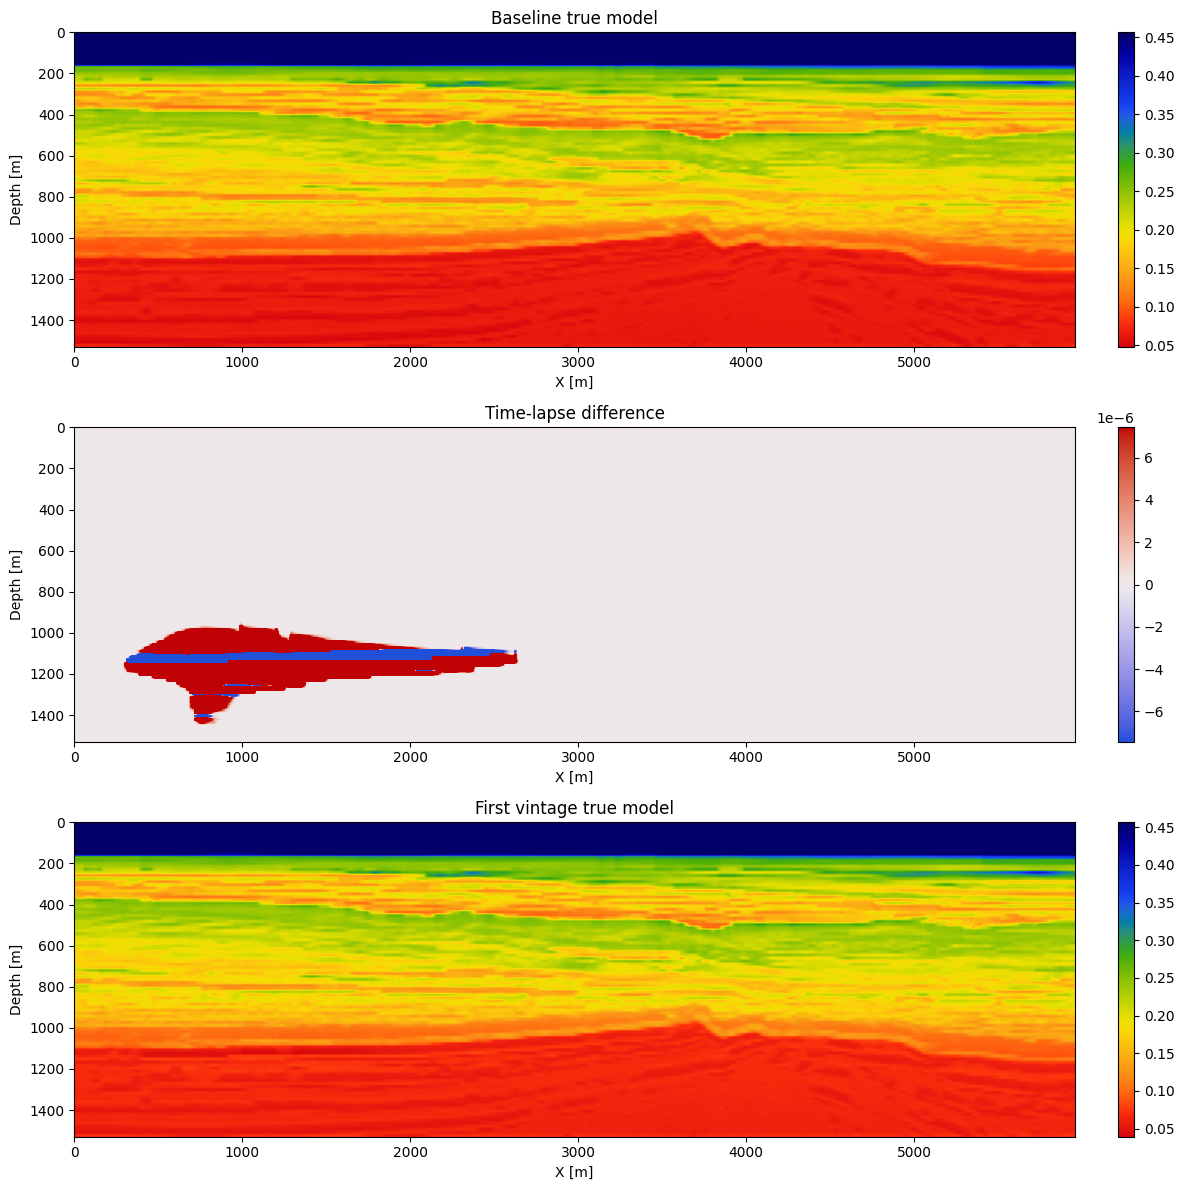

In [8]:
figure(figsize=(12, 12))
subplot(311)
plot_velocity(m_baseline', d; new_fig=false, name="Baseline true model", cmap="cet_rainbow4_r", cbar=true)
subplot(312)
plot_simage(m_monitor' - m_baseline', d; new_fig=false, name="Time-lapse difference", cmap="cet_CET_D1", cbar=true)
subplot(313)
plot_velocity(m_monitor', d; new_fig=false, name="First vintage true model", cmap="cet_rainbow4_r", cbar=true)
tight_layout()

# Data

With our velocity model with CO2 evlolution defined, we can now generate our seismic data using JUDI. First we define our acuisition geometry. We will mimic what is called an ocean-bottom acquisition where measurement are performed along the bottom of the ocean with marine vessels firing the sources at the surface.

In [27]:
# Some acquisition parameters
timeD = 3000f0  # We record the pressure at the receivers for 3000ms (3 Sec) for each source
dtD = 2f0   # We sample the measurements every 2 ms
f0 = 0.0145f0  # We use a 14.5Hz source (0.0145 KHz since we measure time in ms) and band pass it to a realitic frequency band
wavelet = filter_data(ricker_wavelet(timeD, dtD, f0), 4f0; fmin=3, fmax=15);

In [36]:
# Source coordinates in physical units (m)
xsrc = convertToCell(range(start=30f0, step=200f0, stop=(n[1]-1)*d[1]-30f0))   # Sources are every 200m at the surface.
nsrc = length(xsrc)
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc)) # Set y coordinate to zero since it's 2D
zsrc = convertToCell(range(d[1], stop=d[1], length=nsrc))  # Sources at 15m depth

# JUDI geometry object
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 30 sources


In [37]:
# Receivers (measurments) coordinates in phyisical units
xrec = range(start=60f0, step=60f0, stop=(n[1]-1)*d[1]-60f0)  # Receivers every 60m
yrec = 0f0 # WE have to set the y coordiante to zero (or any number) for 2D modeling
zrec = (wb[5:4:end-5] .- 1) .* d[2]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

GeometryIC{Float32} wiht 30 sources


Let's visualize the acqusition overlayed with the model

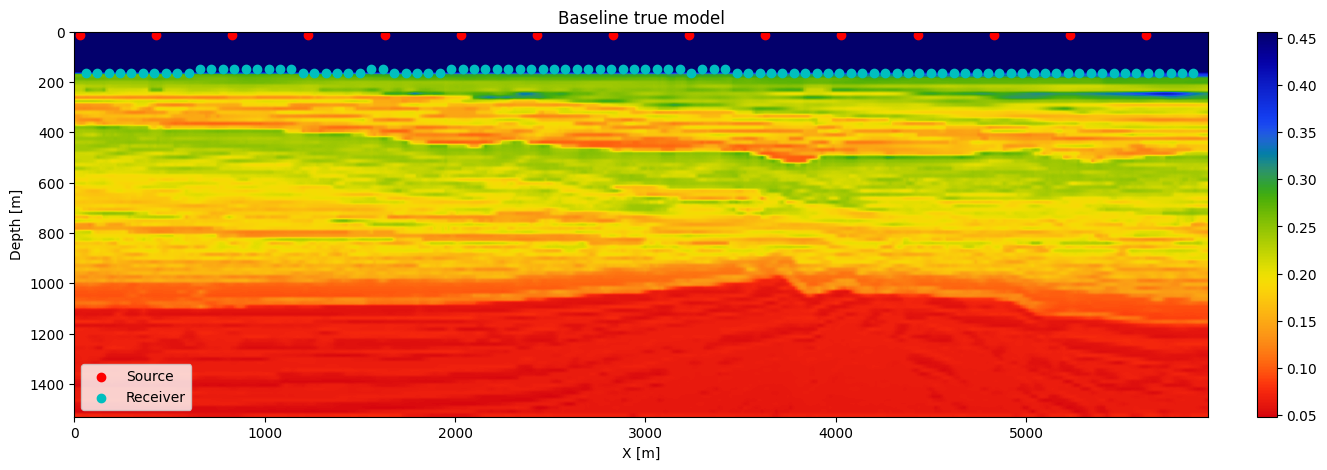

PyObject <matplotlib.legend.Legend object at 0x7f50b4c2c5e0>

In [68]:
figure(figsize=(16, 5))
plot_velocity(m_baseline', d; new_fig=false, name="Baseline true model", cmap="cet_rainbow4_r", cbar=true)
scatter(xsrc[1:2:end], zsrc[1:2:end], c="r", label="Source")    # Sources
scatter(xrec[1:end], zrec[1:end], c="c", label="Receiver")    # receivers
legend(loc="lower left")

# JUDI setup

We can now create our JUDI structures and generate the synthetic data. For a description of JUDI modeling, refer to the tutorials 00_intro_JUDI.ipynb.

In [41]:
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 30 sources


In [42]:
model_baseline = Model(n, d, o, m_baseline; nb=80)
model_monitor = Model(n, d, o, m_monitor; nb=80)

Model (n=(398, 103), d=(15.0f0, 15.0f0), o=(0.0f0, 0.0f0)) with parameters (:m, :rho)

In [43]:
opt = Options(dt_comp=1f0) # We fix the computational time-step to avoid slight variations in numerical scheme leading to differences in the data.
F_baseline = judiModeling(model_baseline, srcGeometry, recGeometry; options=opt)
F_monitor = judiModeling(model_monitor, srcGeometry, recGeometry; options=opt)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)

Now let's define the JUDI modeling operator with the smooth (background) model.

In [48]:
# Define the operator for the background
F0_b = F_baseline(;m=m0)  # F(m0 + dm1) with intial dm1=0
F0_m = F_monitor(;m=m0) # F(m0 + dm1) with intial dm1=0

J1 = judiJacobian(F0_b, q)  # J_x(m0+dm1)
J2 = judiJacobian(F0_m, q)  # J_x(m0+dm2)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)

After we defined the modeling operator, let's generate the data. We  generate both true (observed) and synthetic (theoretical) data.

In [49]:
if isfile("d0_baseline.jld2")
    @load "d0_baseline.jld2" d0_baseline
else
    d0_baseline = F0_b * q  # Synthetic data for the baseline
    @save "d0_baseline.jld2" d0_baseline
end

Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.27 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.35 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.28 s
Operator `forward` ran in 0.31 s
Operator `forward` ran in 0.28 s
Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.31 s
Operator `forward` ran in 0.26 s


In [50]:
if isfile("d0_monitor.jld2")
    @load "d0_monitor.jld2" d0_monitor
else
    d0_monitor = F0_m * q  # Synthetic data for the baseline
    @save "d0_monitor.jld2" d0_monitor
end

Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.28 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.20 s


In [45]:
if isfile("d_baseline.jld2")
    @load "d_baseline.jld2" d_baseline
else
    d_baseline = F_baseline * q  # True data for the baseline
    @save "d_baseline.jld2" d_baseline
end

Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s


In [46]:
if isfile("d_monitor.jld2")
    @load "d_monitor.jld2" d_monitor
else
    d_monitor = F_monitor * q  # True data for the baseline
    @save "d_monitor.jld2" d_monitor
end

Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.27 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.24 s


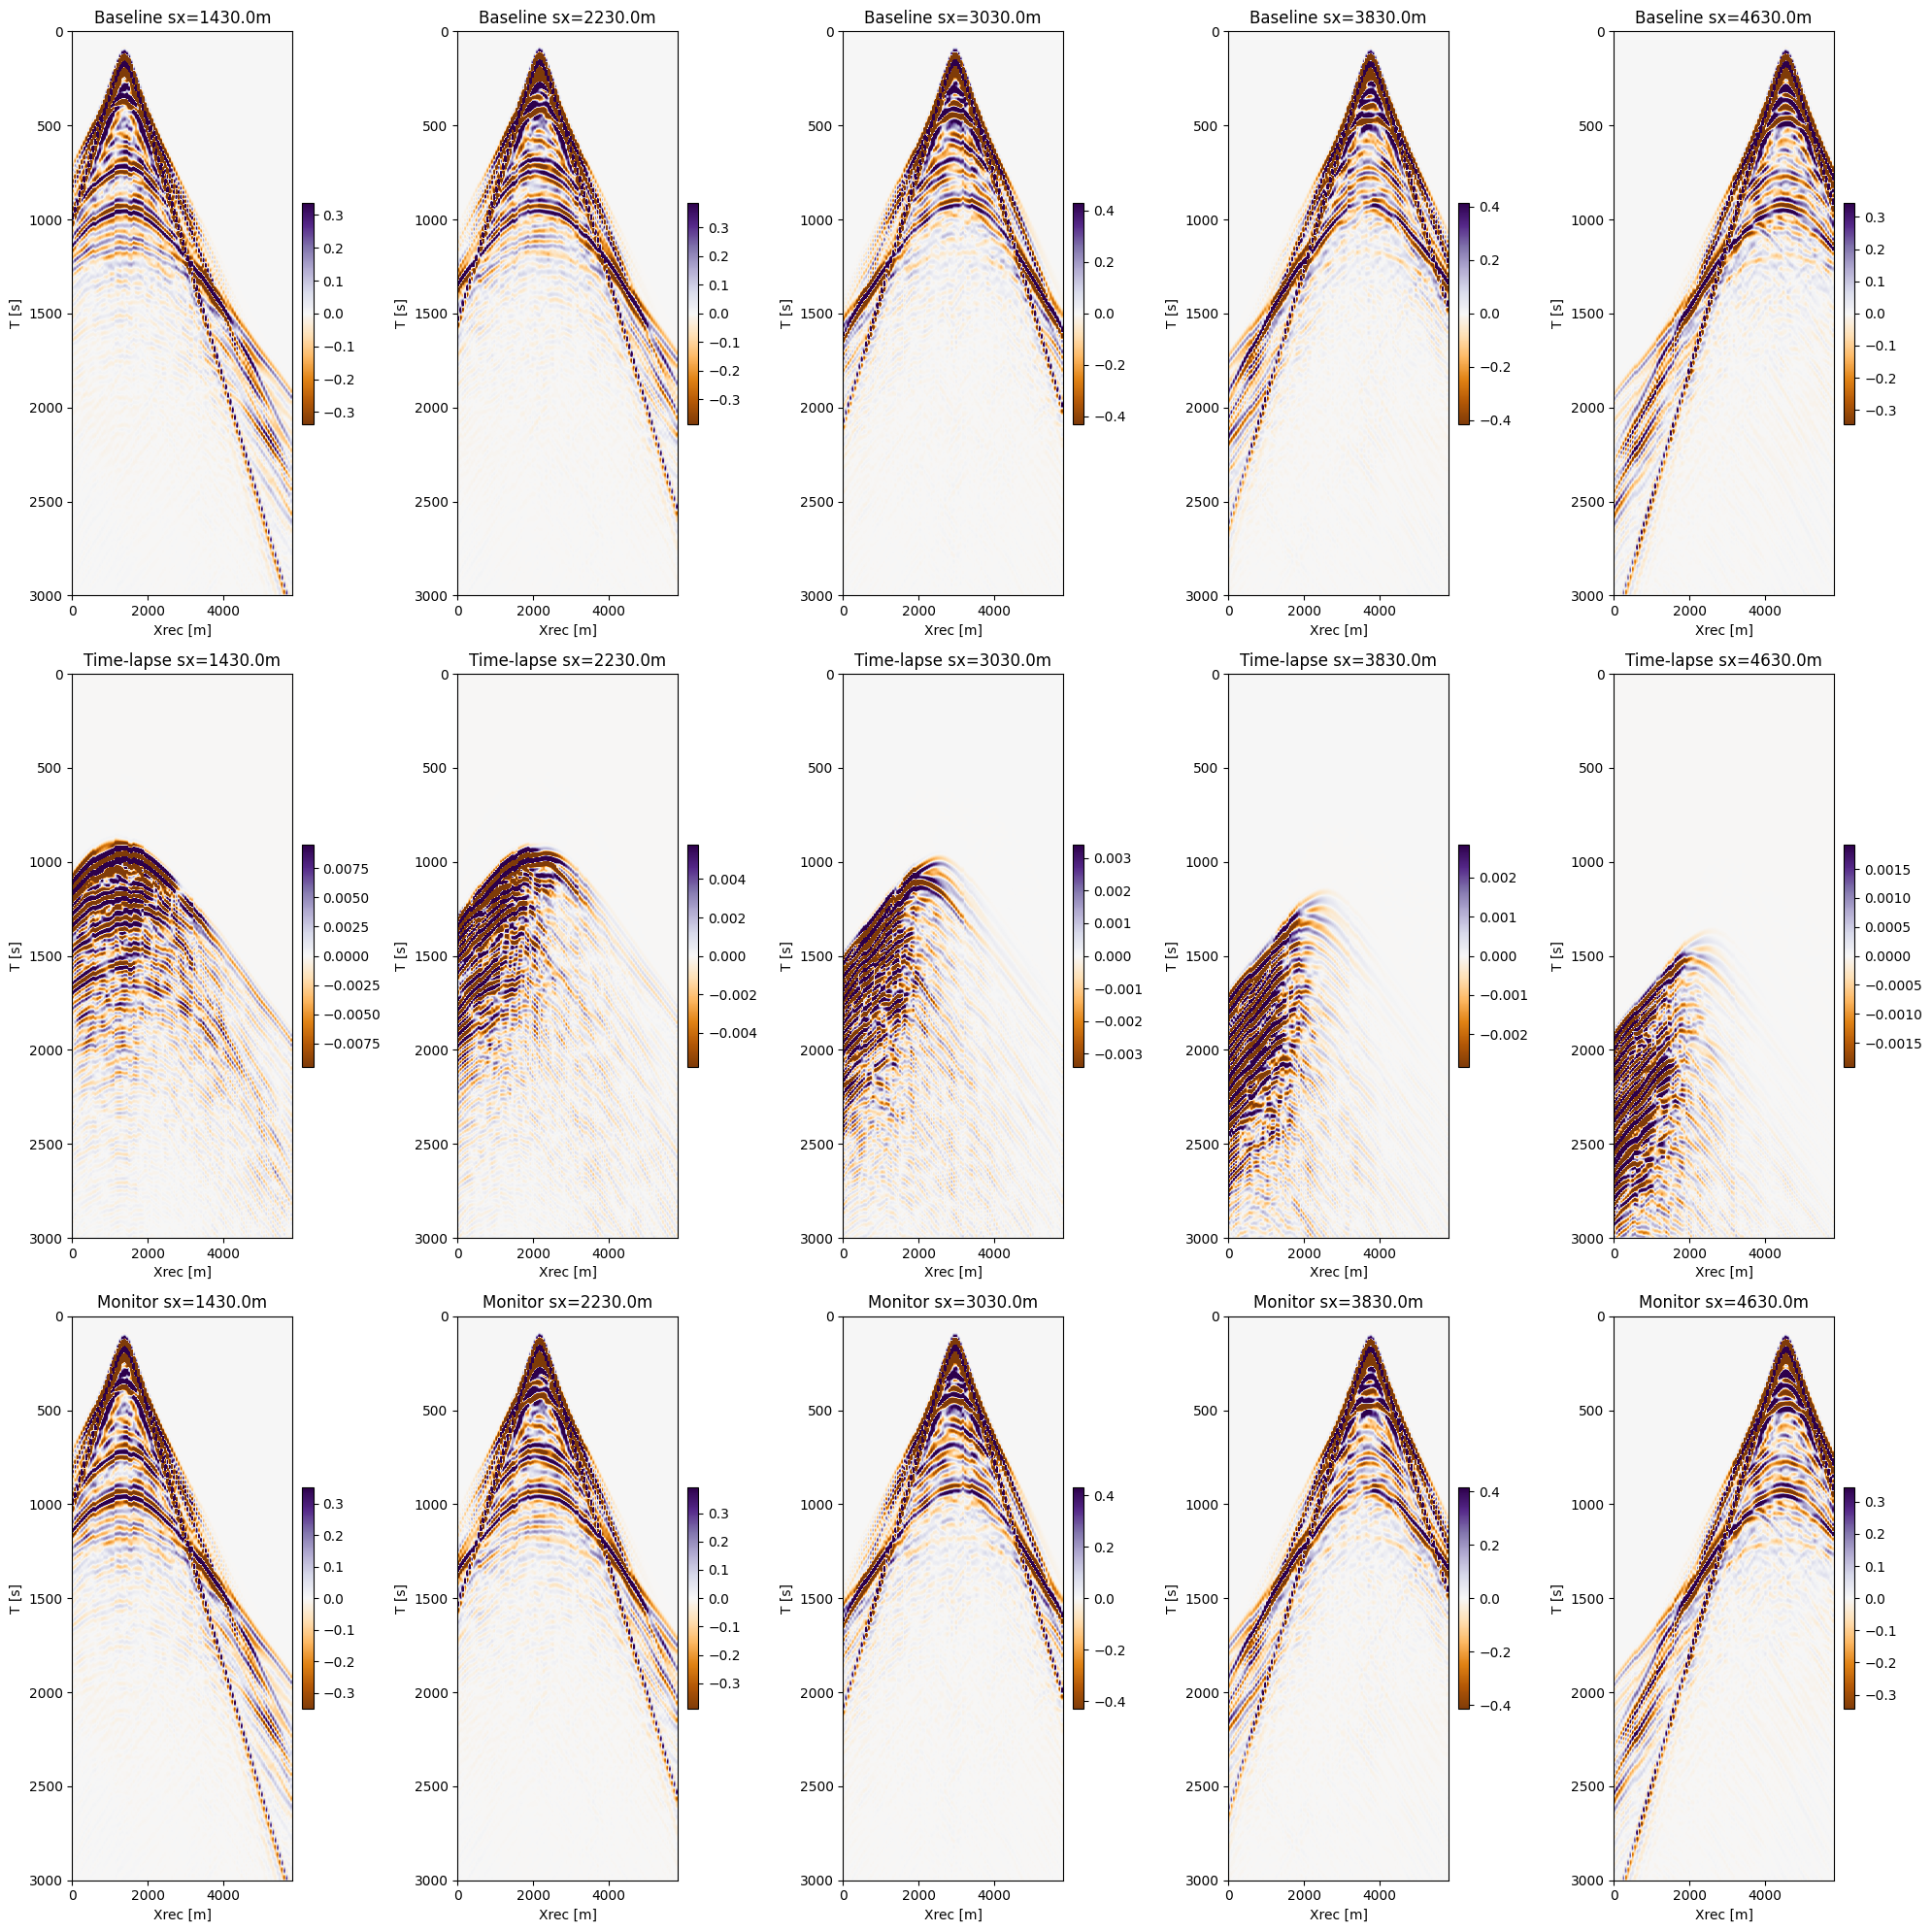

In [47]:
figure(figsize=(20, 20))
for i=1:5
    sxi = (i + 1) * div(nsrc, 7)
    sx = xsrc[sxi][1]
    subplot(3,5,i)
    plot_sdata(d_baseline[sxi]; cmap="PuOr", new_fig=false, name="Baseline sx=$(sx)m", cbar=true)
    subplot(3,5,i+5)
    plot_sdata(d_baseline[sxi] - d_monitor[sxi]; cmap="PuOr", new_fig=false, name="Time-lapse sx=$(sx)m", cbar=true)
    subplot(3,5,i+10)
    plot_sdata(d_monitor[sxi]; cmap="PuOr", new_fig=false, name="Monitor sx=$(sx)m", cbar=true)

end
tight_layout()

In [51]:
rtm_baseline = J1' * (d_baseline - d0_baseline)

Building forward operator
Operator `forward` ran in 0.20 s
Building adjoint born operator
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Opera

PhysicalParameter{Float32, 2} of size (398, 103) with origin (0.0f0, 0.0f0) and spacing (15.0f0, 15.0f0)


In [52]:
rtm_monitor = J1' * (d_monitor - d0_monitor)

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.30 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.

PhysicalParameter{Float32, 2} of size (398, 103) with origin (0.0f0, 0.0f0) and spacing (15.0f0, 15.0f0)


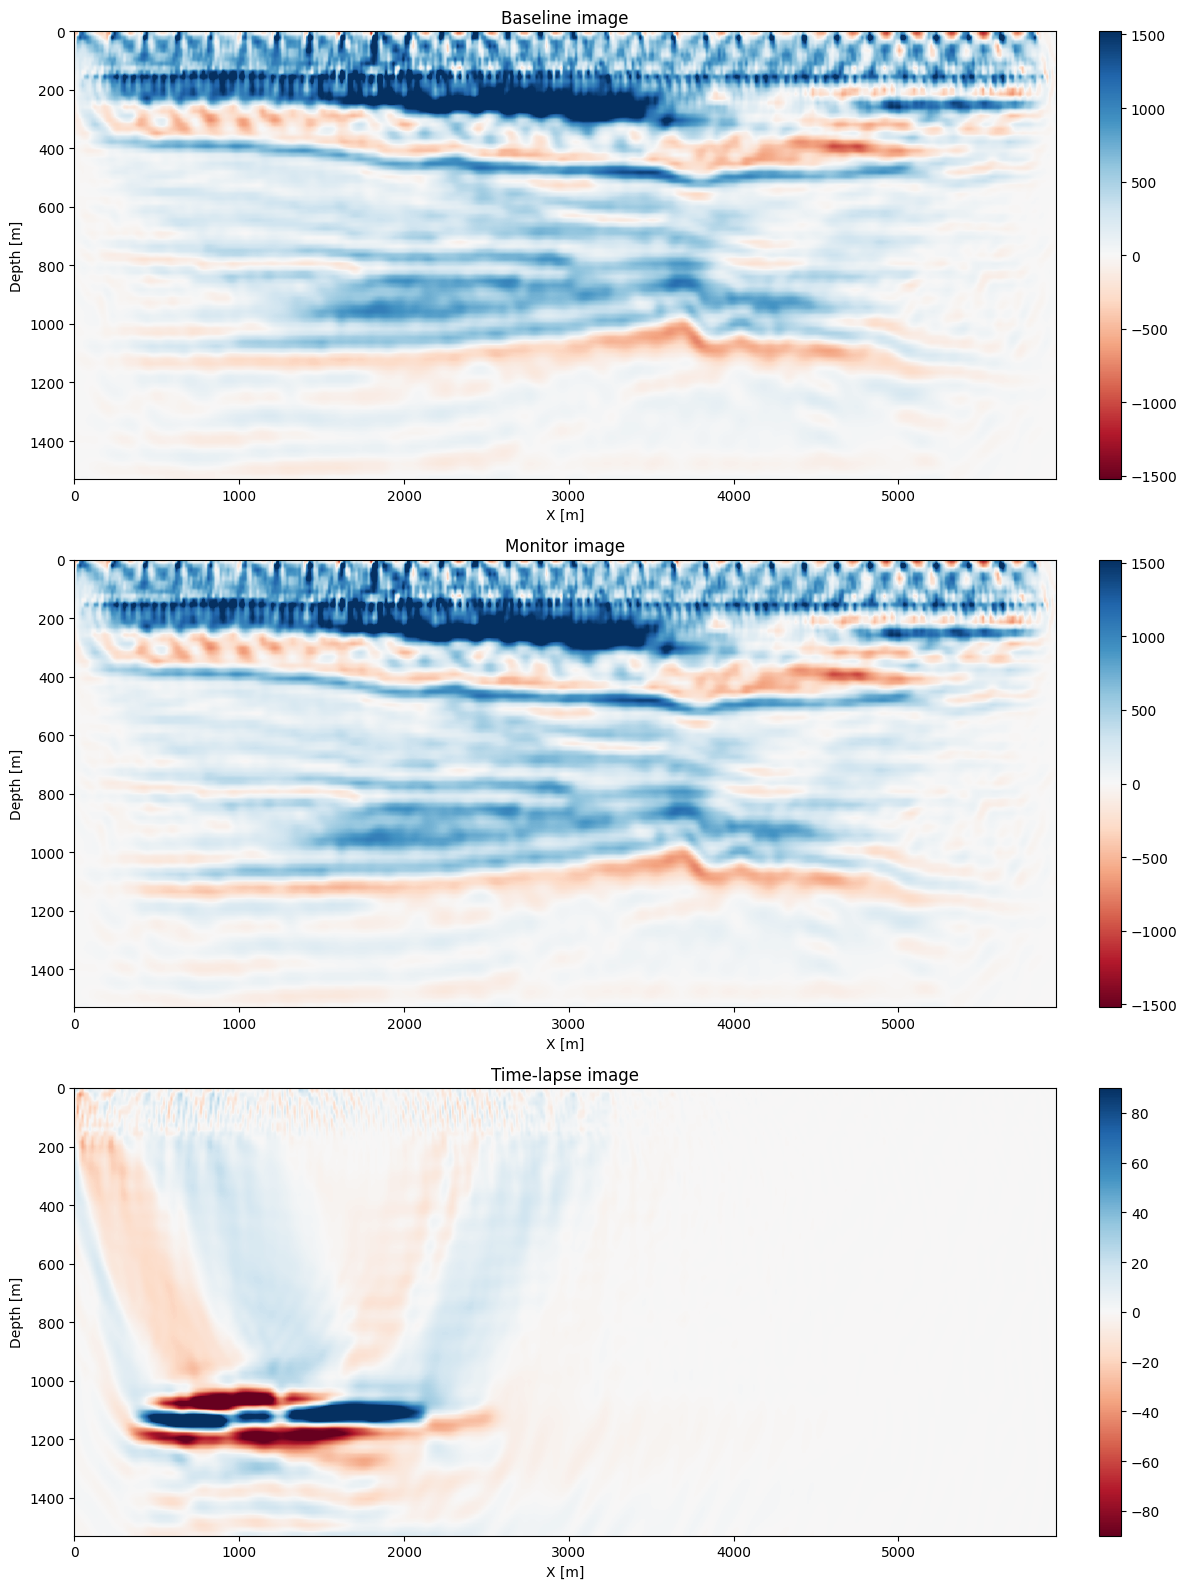

In [64]:
figure(figsize=(12, 16))
subplot(311)
plot_simage(rtm_baseline.data', d; new_fig=false, cmap="RdBu", name="Baseline image", cbar=true, perc=98)
subplot(312)
plot_simage(rtm_monitor.data', d; new_fig=false, cmap="RdBu", name="Monitor image", cbar=true, perc=98)
subplot(313)
plot_simage(rtm_baseline.data' - rtm_monitor.data', d; new_fig=false, cmap="RdBu", name="Time-lapse image", cbar=true, perc=99)
tight_layout()

For the joint recovery model (JRM) of time-lapse imaging, please refer to this repository https://github.com/slimgroup/Software.SEG2021